## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.1.0
0.9.0


## Generate Data

In [3]:
df = pd.DataFrame(
    data={'date': pd.date_range(start='2018-01-01', end='2020-12-31', freq='D')}
)

n = df.shape[0]

In [4]:
np.random.seed(seed=42)

df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

#df['x'] = np.random.uniform(low=0.0, high=5.0, size=n)
df['x'] = 0.0 #df['x'].apply(lambda x: x if x > 4.8 else 0.0)

df['y'] = 5*df['x'] \
    + np.power(df.index.values, 1/3) \
    + 2*np.cos(2*np.pi*df['month']/12) + 0.5*np.sin(2*np.pi*df['month']/12)\
    + 1.3*np.cos(2*np.pi*df['day_of_week']/6) \
    + 2*np.sin(2*np.pi*df['day_of_month']/30) \
    + np.random.normal(loc=0.0, scale=0.5, size=n)

#df['y'] = df['y'] + 0.8*df['y'].shift(1)

df['y'] = df['y'].fillna(method='backfill').astype(np.float32)

df.head(10)

,date,day_of_week,day_of_month,month,year,x,y
0,2018-01-01,0,1,1,2018,0.0,3.946231
1,2018-01-02,1,2,1,2018,0.0,4.376392
2,2018-01-03,2,3,1,2018,0.0,4.091387
3,2018-01-04,3,4,1,2018,0.0,4.372105
4,2018-01-05,4,5,1,2018,0.0,4.534426
5,2018-01-06,5,6,1,2018,0.0,6.127071
6,2018-01-07,6,7,1,2018,0.0,7.877821
7,2018-01-08,0,8,1,2018,0.0,7.567743
8,2018-01-09,1,9,1,2018,0.0,6.299427
9,2018-01-10,2,10,1,2018,0.0,5.415465


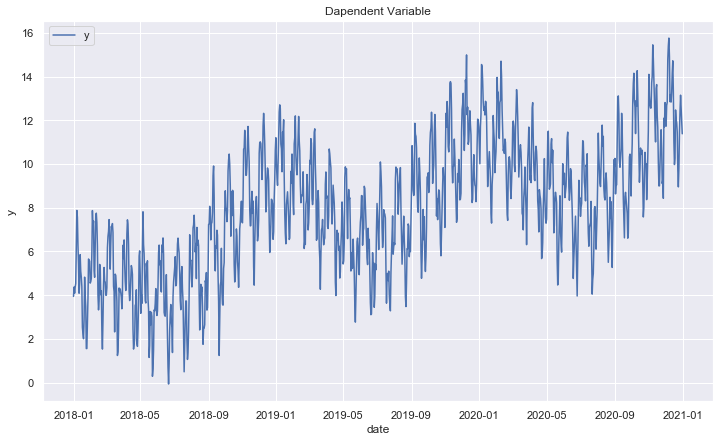

In [5]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable');

In [6]:
threshold_date = '2020-07-01'
mask = df['date'] < threshold_date

df_train = df[mask]
df_test = df[~ mask]

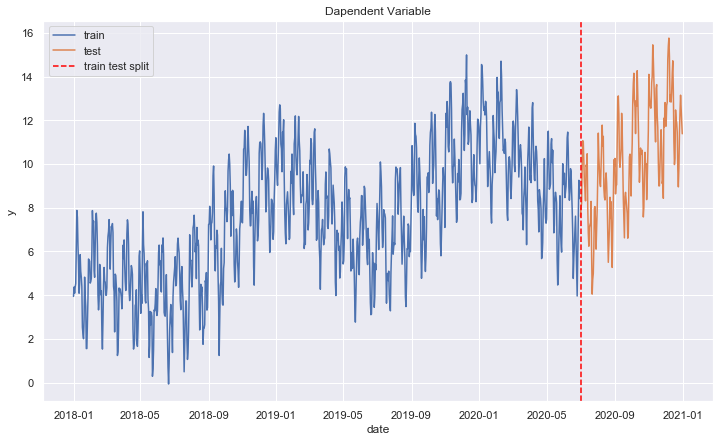

In [7]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='train', data=df_train, ax=ax)
sns.lineplot(x='date', y='y', label='test', data=df_test, ax=ax)
ax.axvline(threshold_date, color='red', linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable');

## Time Series Analysis

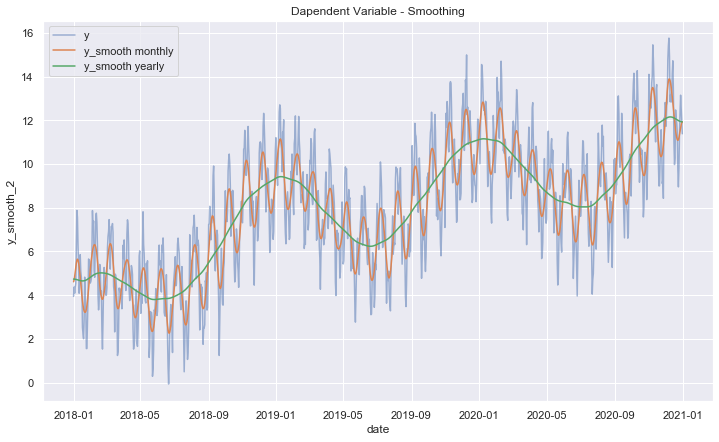

In [8]:
from scipy.ndimage import gaussian_filter

df_smooth = df \
    .assign(y_smooth_1 = lambda x: gaussian_filter(input=x['y'], sigma=3.5)) \
    .assign(y_smooth_2 = lambda x: gaussian_filter(input=x['y'], sigma=15)) \

fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', label='y', data=df_smooth, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='y_smooth_1', label='y_smooth monthly', data=df_smooth, ax=ax)
sns.lineplot(x='date', y='y_smooth_2', label='y_smooth yearly', data=df_smooth, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dapendent Variable - Smoothing');

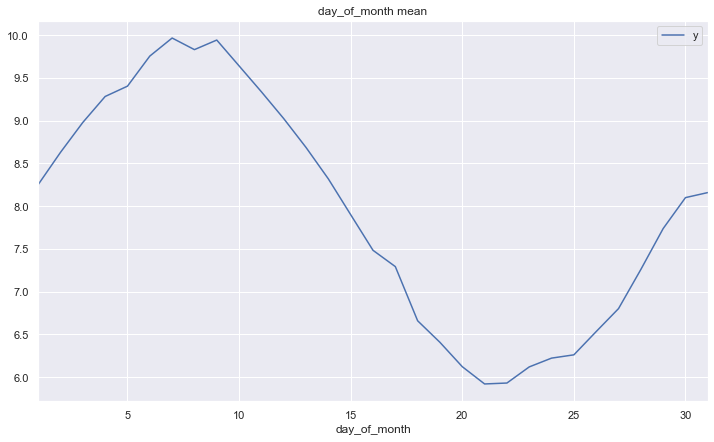

In [9]:
fig, ax = plt.subplots()
df.groupby('day_of_month').agg({'y': np.mean}).plot(ax=ax)
ax.set(title='day_of_month mean');

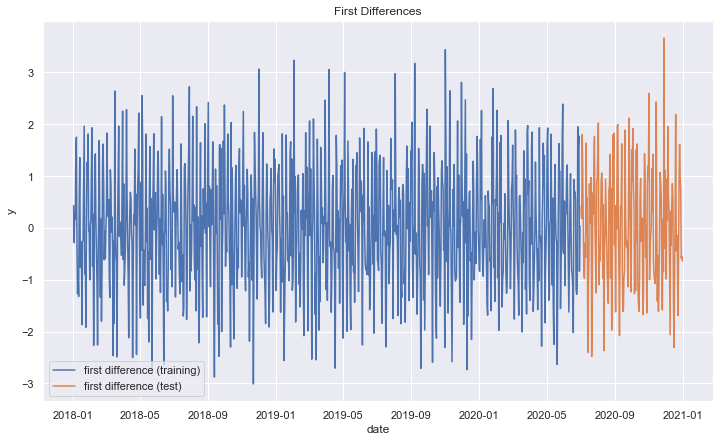

In [10]:
fig, ax = plt.subplots()

sns.lineplot(
    x=df_train['date'], 
    y=df_train['y'] - df_train['y'].shift(1), 
    label='first difference (training)', ax=ax
)

sns.lineplot(
    x=df_test['date'], 
    y=df_test['y'] - df_test['y'].shift(1), 
    label='first difference (test)', ax=ax
)

ax.legend(loc='lower left')
ax.set(title='First Differences');

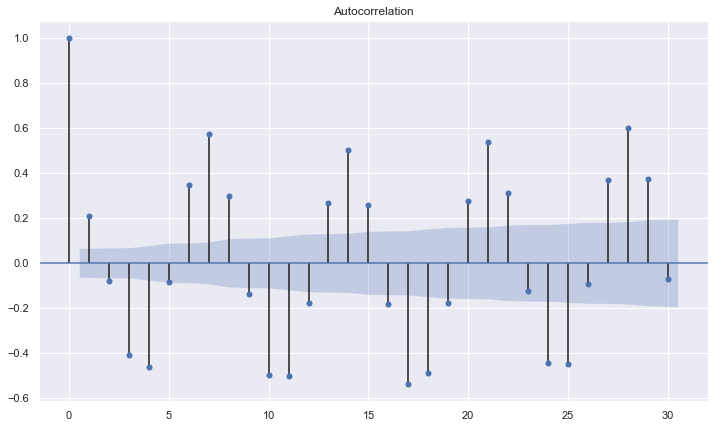

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y_diff = (df_train['y'] - df_train['y'].shift(1))[1:]

fig, ax = plt.subplots()
plot_acf(x=y_diff, ax=ax);

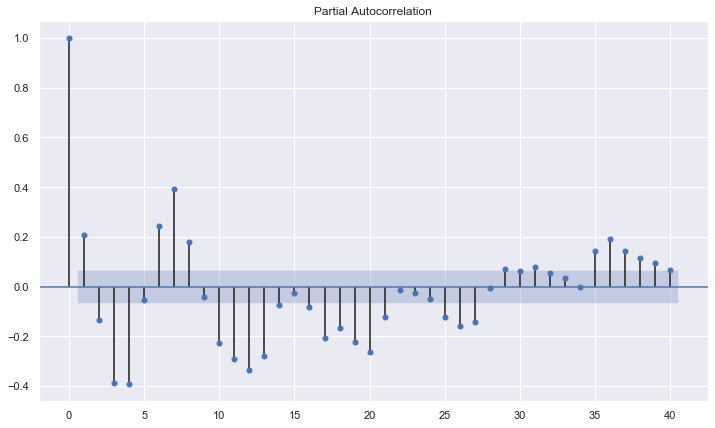

In [12]:
fig, ax = plt.subplots()
plot_pacf(x=y_diff, ax=ax, lags=40);

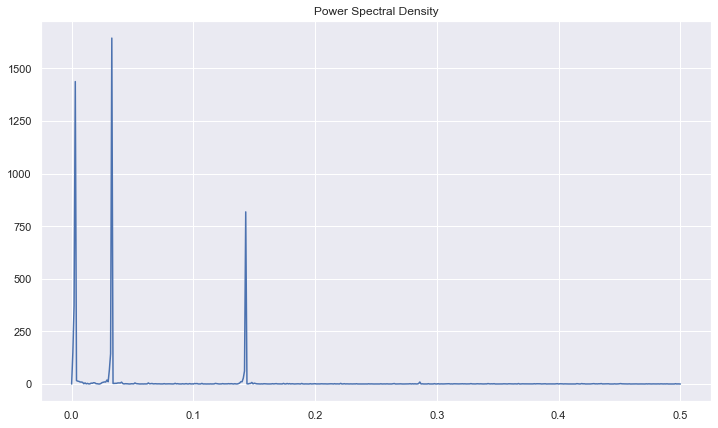

In [38]:
from scipy import signal

f, Pxx_den = signal.periodogram(x=df_train['y'], nfft=1e3, detrend='linear')

fig, ax = plt.subplots()
sns.lineplot(x=f, y=Pxx_den, ax=ax)
ax.set(title='Power Spectral Density');

In [40]:
sort_freq_index = np.argsort(a=Pxx_den)[::-1]

periodogram_df = pd.DataFrame(
    {'sort_freq': f[sort_freq_index], 'Pxx_den': Pxx_den[sort_freq_index]}
)

periodogram_df.assign(days = lambda x: 1/x['sort_freq']).head(5)

,sort_freq,Pxx_den,days
0,0.033,1643.829346,30.303030
1,0.003,1437.180664,333.333333
2,0.143,817.968079,6.993007
3,0.002,371.126282,500.000000
4,0.001,149.648376,1000.000000


## Define Model

In [15]:
# Local linear trend. 
local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=df_train['y'], 
    name='local_linear_trend',
)

num_days_per_month = np.array(
  [[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
   [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31]] # year with leap day
)  

month_of_year = tfp.sts.Seasonal(
  num_seasons=12,
  num_steps_per_season=num_days_per_month,
  name='month_of_year'
)

day_of_week = tfp.sts.Seasonal(
    num_seasons=7, 
    num_steps_per_season=1,
    observed_time_series=df_train['y'], 
    name='day_of_week',
)

design_matrix = tf.reshape(
    df['day_of_month'].apply(lambda x: np.sin(2*np.pi*x/30)).values.astype(np.float32), 
    (-1, 1)
)

day_of_month = tfp.sts.LinearRegression(
    design_matrix=design_matrix,
    name='day_of_month'
)

model_components = [
    local_linear_trend, 
    month_of_year, 
    day_of_week, 
    day_of_month
]

toy_model = tfp.sts.Sum(
    components=model_components, 
    observed_time_series=df_train['y']
)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


## Model Fit

In [16]:
# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=toy_model)

In [17]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=0.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=toy_model.joint_log_prob(
            observed_time_series=df_train['y']),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
        seed=42
    )
    return elbo_loss_curve

elbo_loss_curve = train()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


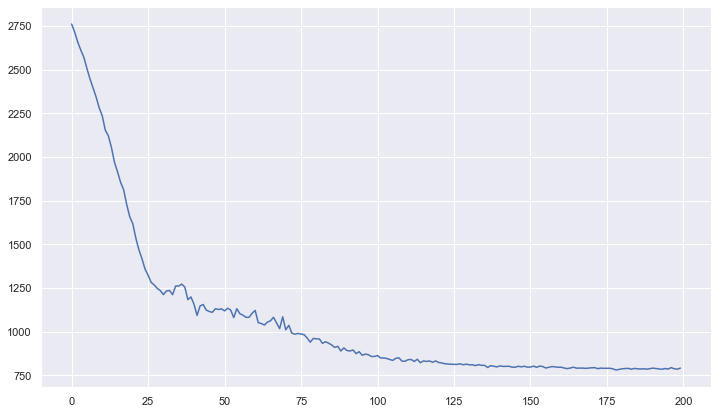

In [18]:
fig, ax = plt.subplots()
ax.plot(elbo_loss_curve)

In [19]:
q_samples = variational_posteriors.sample(75)

In [20]:
print("Inferred parameters:")
for param in toy_model.parameters:
    print("{}: {} +- {}".format(
        param.name,
        np.mean(q_samples[param.name], axis=0),
        np.std(q_samples[param.name], axis=0))
    )

Inferred parameters:
observation_noise_scale: 0.4715413451194763 +- 0.012301009148359299
local_linear_trend/_level_scale: 0.012827478349208832 +- 0.008337722159922123
local_linear_trend/_slope_scale: 0.0012378811370581388 +- 0.00039981192094273865
month_of_year/_drift_scale: 0.004956931807100773 +- 0.010450454428792
day_of_week/_drift_scale: 0.03984328731894493 +- 0.005195909179747105
day_of_month/_weights: [2.0672338] +- [0.02570156]


In [21]:
forecast_window = num_days_per_month[1][6:13].sum()

forecast_dist = tfp.sts.forecast(
    toy_model,
    observed_time_series=df_train['y'],
    parameter_samples=q_samples,
    num_steps_forecast=forecast_window 
)

## Model Predictions

In [22]:
num_days_per_month[1][6:13].sum()

184

In [23]:
num_samples=100

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy().flatten(),
    forecast_dist.stddev().numpy().flatten(),
    forecast_dist.sample(num_samples).numpy().flatten()
)

In [24]:
df_test['y_pred'] = forecast_mean.copy()
df_test['y_pred_std'] = forecast_scale.copy()
df_test['errors'] = df_test['y'] - df_test['y_pred']

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

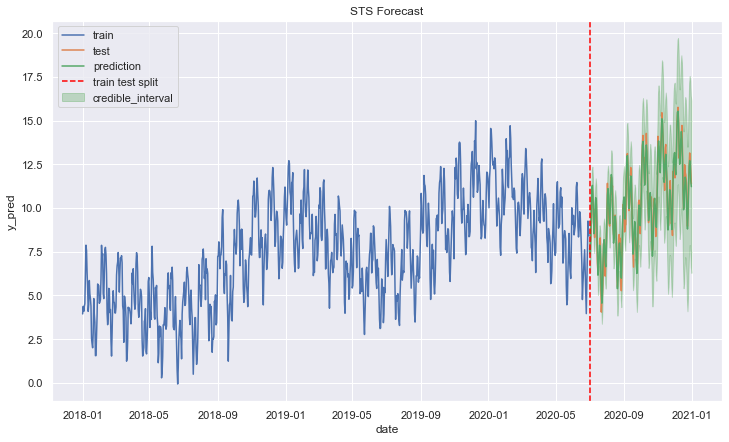

In [25]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test['date'],
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color='green', 
    alpha=0.2,
    label='credible_interval'
)

sns.lineplot(x='date', y='y', label='train', data=df_train, ax=ax)
sns.lineplot(x='date', y='y', label='test', data=df_test, ax=ax)
sns.lineplot(x='date', y='y_pred', label='prediction', data=df_test, ax=ax)

ax.axvline(threshold_date, color='red', linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

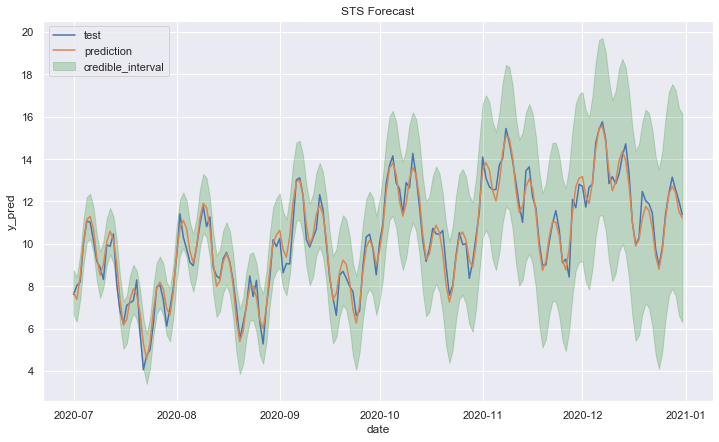

In [26]:
fig, ax = plt.subplots()

ax.fill_between(
    x=df_test['date'],
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color='green', 
    alpha=0.2,
    label='credible_interval'
)
sns.lineplot(x='date', y='y', label='test', data=df_test, ax=ax)
sns.lineplot(x='date', y='y_pred', label='prediction', data=df_test, ax=ax)
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

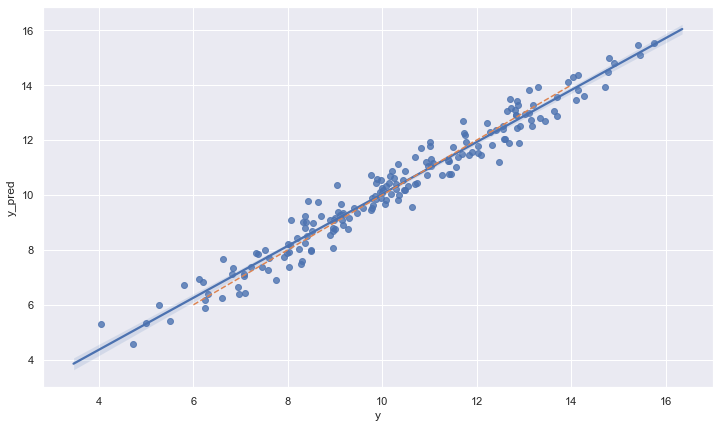

In [28]:
fig, ax = plt.subplots()

d_x = np.linspace(start=6.0, stop=14.0, num=100)

sns.regplot(x='y', y='y_pred', data=df_test, ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, ax=ax)
ax.lines[1].set_linestyle('--')

- Errors

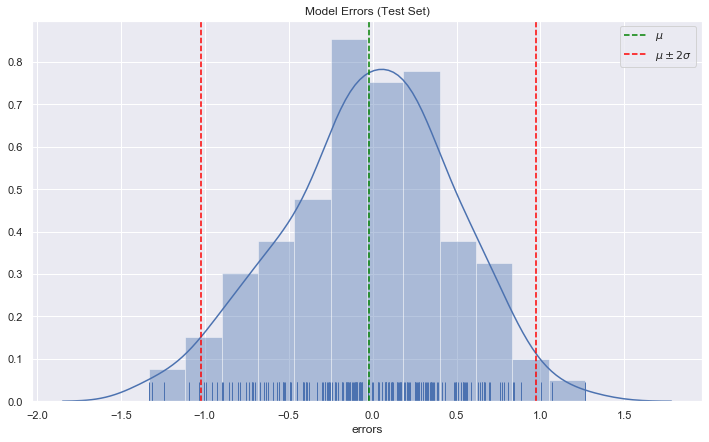

In [29]:
fig, ax = plt.subplots()
sns.distplot(a=df_test['errors'], ax=ax, rug=True)
ax.axvline(df_test['errors'].mean(), color='green', linestyle='--', label=r'$\mu$ ')
ax.axvline(df_test['errors'].mean() + 2*df_test['errors'].std(), color='red', linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(df_test['errors'].mean() - 2*df_test['errors'].std(), color='red', linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

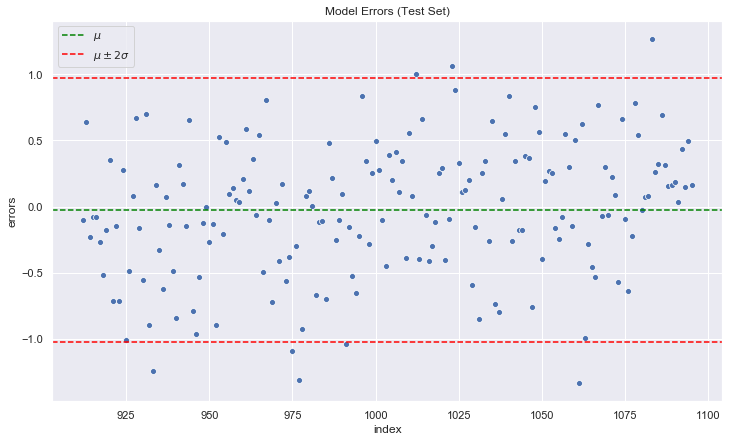

In [30]:
fig, ax = plt.subplots()
sns.scatterplot(x='index', y='errors', data=df_test.reset_index(), ax=ax)
ax.axhline(df_test['errors'].mean(), color='green', linestyle='--', label=r'$\mu$ ')
ax.axhline(df_test['errors'].mean() + 2*df_test['errors'].std(), color='red', linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(df_test['errors'].mean() - 2*df_test['errors'].std(), color='red', linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

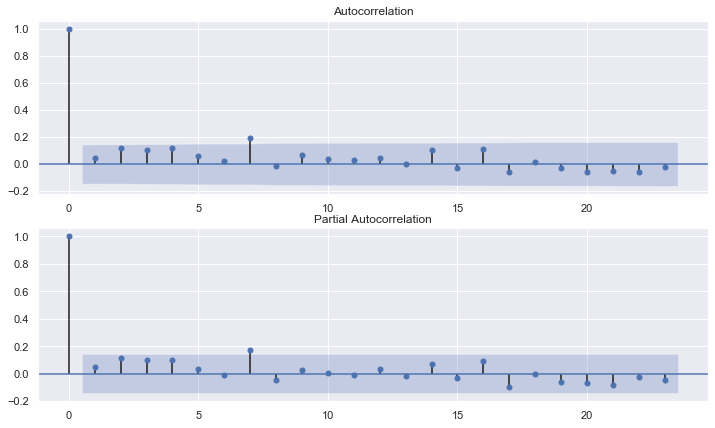

In [31]:
fig, ax = plt.subplots(2, 1)
plot_acf(x=df_test['errors'], ax=ax[0])
plot_pacf(x=df_test['errors'], ax=ax[1]);

## Decomposition

In [32]:
component_dists = tfp.sts.decompose_by_component(
    model=toy_model,
    observed_time_series=df_train['y'],
    parameter_samples=q_samples
)

In [33]:
component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

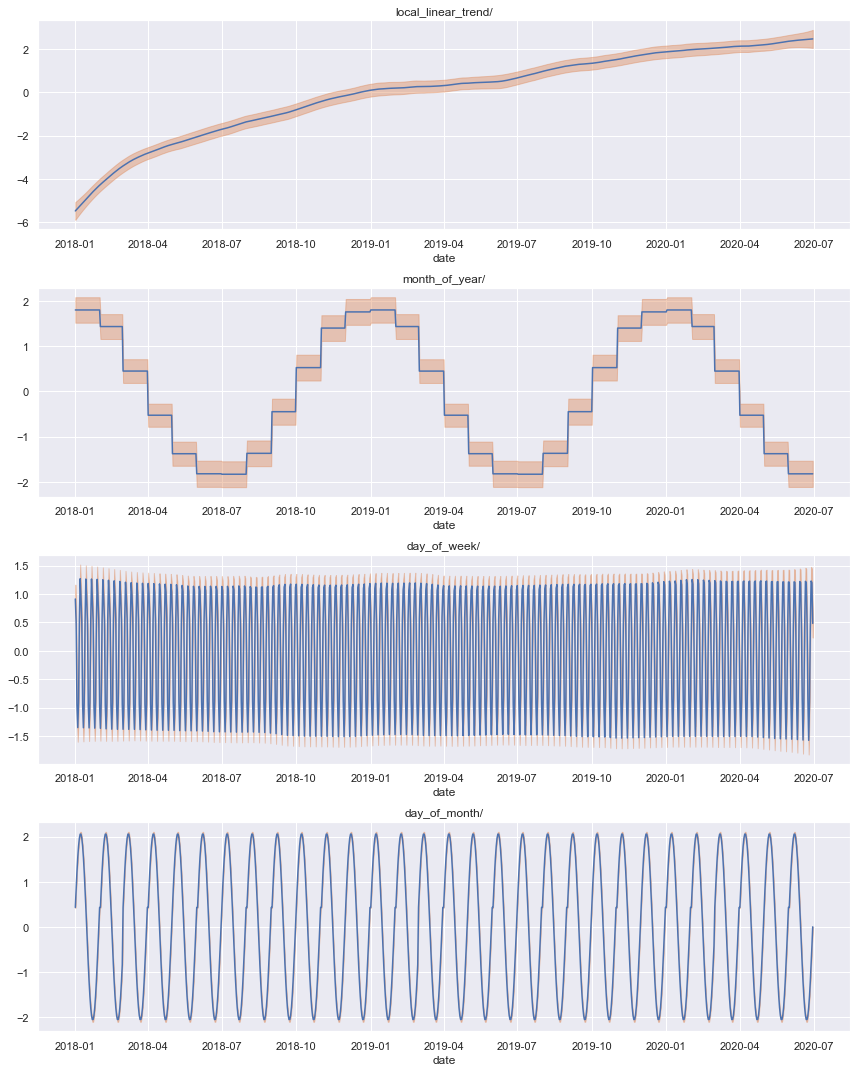

In [41]:
num_components = len(component_means)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig, ax = plt.subplots(num_components, 1, figsize= (12, 15))

for i, component_name in enumerate(component_means.keys()):
    component_mean = component_means[component_name]
    component_stddev = component_stddevs[component_name]
    
    sns.lineplot(x=df_train['date'], y=component_mean, color=c1, ax=ax[i])
    
    ax[i].fill_between(
        x=df_train['date'],
        y1=component_mean-2*component_stddev,
        y2=component_mean+2*component_stddev,
        alpha=0.4, 
        color=c2
    )
    
    ax[i].set(title=component_name)

plt.tight_layout()